## Predictive Modeling


In [2]:
# Import all required libraries here

# Analytical tools
import pandas as pd
from summarytools import dfSummary
import pycaret.classification as pc
import sweetviz as sv 

# Import custom modules
import custom_pipeline as cp
from data_processing import Input

### General Plan

1. **Data Preprocessing**: Clean and preprocess the data using custom tools.

2. **Metric Selection**: Decide on metric to use. Evaluate the suitability of various metrics such as Recall, Precision, Accuracy, and F1 Score.

4. **Hyperparameter Tuning**: Play around with hyperparameters of the most suitable models to see if predictive power can be improved further (if time allows!).

5. **Prediction**: Make predictions on the test dataset and save the results to the file ```predictions.xlsx```.

6. **Deployment-ready pipeline**: Save pipelines and make model deployment-ready. Integrate model to an existing (in theory) system. Justify the approach.

7. **Continuous Monitoring**: If time allows, launch MLFLow (locally or in cloud) and add model to constantly trck its performance over time


In [8]:
# Upload Data and Clean it automatically using customly developed tools
df = Input('data/train_file.csv').preprocess()
dfSummary(df, is_collapsible=True)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,age[int64],Mean (sd) : 40.1 (10.2)min < med < max:20.0 < 38.0 < 70.0IQR (CV) : 15.0 (3.9),51 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACgElEQVR4nO3cP47aQBSA8TdhWQ0g2eKPoOMCK6VAouEAKXPYHCEFRWpuQIeEkBHOWhjjFFmUbLQBMbbxs/39+tl18cnwhrFNmqYCaPGp7AsA/vZU9gV8xBjTEZFnx+XHNE1f87wePI66II0xneFw+NXzvL7L+v1+vzPGfCPKalIXpIg8e57XXywWr77vR/csDILALpfL/na7fRYRgqwgjUGKiIjv+9F4PP7psLST+8XgYRhqoApBQhWChCpqv0O6SpKkLSKeMcZlOVtGJatVkGEYtuM4/jydTlutVuuuCV2ELSMNahXk8Xh8stZ2Z7NZNJlMdvesZctIh1oFedHr9dgyqiiGGqhCkFCFIKEKQUIVgoQqBAlVCBKqECRUIUioQpBQpZY/HbripFD5CPINJ4V0IMg3nBTSgSD/wUmhcjHUQBWChCp8ZOeECT0fBJkDJvT8FBZkhhdGeefzuZ339RSJCT0/hQSZ5YVRcRzbJEleoij6LiIu025pmNCzK+oO6fzCqPV63V+tVt3T6dQq6NqgWKHfIV1eGLXb7bhbNBjbPlCFKVsBtoz+IMiSsWX0HkGWjC2j9whSCbaMfmOogSrcISuubgMRQVZYHQcigqywOg5EBFkDdRqIGGqgCkFCFYKEKgQJVQgSqhAkVCFIqEKQUIUgoQpBQpWrPx026dlq6PDfIJv6bDXKde0OybPVeLibp314thofyfB1TuTKwWCOnzVYhtPmdjAYfPF9v+fyf68dDCbIhspy2jyOYysiL/P5/MdoNNrfs/bWwWCCbKgsp80vM4K1Ns77YDBBNpzLafMiZ4SbQQZBYO/9o4fDwYqIhGFoN5tNl7WsvbjV0y9rzLhuBKPgiAAAAABJRU5ErkJggg=="">",0(0.0%)
2,job[category],1. admin.2. blue-collar3. technician4. services5. management6. retired7. entrepreneur8. self-employed9. housemaid10. unemployed11. other,"7,704 (24.7%)7,043 (22.6%)5,137 (16.5%)3,108 (10.0%)2,283 (7.3%)1,338 (4.3%)1,150 (3.7%)1,090 (3.5%)843 (2.7%)791 (2.5%)702 (2.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAERElEQVR4nO3dQU4bWQBF0e8IRZ2JLYTEYryIXmwvwrtBCA9ClIl70EkrgE0wrrq2yDmzzGpw9a0q/UcWu91uQOHTuR+AP4fYyIiNjNjIiI2M2MiIjYzYyIiNzGKM8WWM8fncD7LH991u93juh2A6Vzc3N38vl8vrcz/Ic9vt9n6xWPwjuI/jarlcXq/X68fVavXt3A/z08PDw1+bzeb67u7u8xhDbB/E1RhjrFarb7e3t1/P/TDPfDn3AzAtLwhkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEbmaoz/7o+d+0F+dWnPwzSuttvt/WazuR4Xdn9su93ejzG+n/s5mI4NApmFP5lF5dJONqfZB3ZR6yqLqo/tYtZVFlUf36Wtqy7qjZhp+ahLRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRG5mIGL5fwDMzrogYvRi4fm2vhZAxeyJQnm1PrD5cNXoxZSAYvxiyM0Q5ezv62y3n5qEtGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEYmGbwYszBGOHgxZsG1cDIGL2S8IJA59WfUTyNvdtK6ymKKY7x7XWUxxbFOXVdZTPFmXhDIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIvHtdZTHFsU5aV1lMcQzXwslYV5E59mRzkvFuRw1eDFw4xZsHLwYunOrYwYuBC+/moy4ZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZNw9eDFw41VGDFwMXTuFaOBmDFzK/O9mcZEzm1cGLgQtTOjh4MXBhar8bvBi4MBkfdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjczBdZU1FVN7dV1lTcWUbBDIWFeRee1kc6oxqYPrKssqprZ3XWVZxRxeW1dZVjEpH3XJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjI7B28GLswh4ODF2MXpuZaOBmDFzKHTjanGpPbO3gxdmEOLwYvxi7M5dDgxdiFyfmoS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERubF4MXYhbnsHbwYuzAH18LJGLyQ8YJAZt/PqJ9QZvFiXWVZxVyerKssq5jTvnWVZRWz8IJARmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRG5sm6yrKKOb1YV1lWMRfXwslYV5FxspExeCFj8ELG4IWMj7pkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkDF7IGLyQcS2cjMELmecnm1ON2TwZvBi7MKdPPwcv6/X68Ud0z/87SJjE/4OXH/82dmE2PuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGReTJ4gTn9OngxdmFWroWTMXgh4wWBjNjIiI2M2MiIjYzYyIiNjNjIiI3Mv7A6QoOXcIsOAAAAAElFTkSuQmCC"">",0(0.0%)
3,marital[category],1. married2. single3. divorced,"18,827 (60.4%)8,760 (28.1%)3,602 (11.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmElEQVR4nO3bQWrCUBRG4ZsSpE4SguBiXEQX20VkNyK+gYqTdNBpqQ7Cebzc863gIgclwb9bliUkwkftA5RHFxH7iNjVPiSh57Is99pHkPrD4fA1DMNU+5BsSimXruu+MwXXD8MwnU6n+ziOj9rHZHG9Xj/neZ7O5/MuIvLEFhExjuPjeDzeah+TzL72ATQfEIQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmH6iN//V9U+JJOsn3dfSrnM8zxFwv9X1VRKuUTEs/YdJDcI9aTbIHRO+URp8Zst3TfCVjS3rsq4StqKptZVWVdJW9Hiusqn5kb5UlcYYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxOmqXVVK3fqb82tqzKukrbCDYIwrquE8QFBmDV/Rv15079Wm/

### Definitions of Metrics (KPIs used to measure how well selected model perfroms)

<details>

**Recall (Sensitivity, True Positive Rate)**:
Recall is the ratio of correctly predicted positive observations to all the actual positives. It answers the question: "Of all the actual positive cases, how many did we correctly identify?"

$$ \text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}} $$

**Precision**:
Precision is the ratio of correctly predicted positive observations to the total predicted positives. It answers the question: "Of all the cases we predicted as positive, how many are actually positive?"

$$ \text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}} $$

**Accuracy**:
Accuracy is the ratio of correctly predicted observations (both positive and negative) to the total observations. It answers the question: "How often is the classifier correct?"

$$ \text{Accuracy} = \frac{\text{True Positives (TP)} + \text{True Negatives (TN)}}{\text{Total Observations}} $$

**F1 Score**:
The F1 score is the harmonic mean of precision and recall. It provides a single metric that balances both concerns. It is particularly useful when you need to balance the trade-off between precision and recall.

$$ \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

</details>

##### When to Use Each Metric

| Metric| When to Use
|--------------|-------------------------------------------------------------------------------------------------|
| **Recall**   | Use when the cost of false negatives is high. For example, if missing an opportunity to invest in campaign that will be favored by customers from Group 1 |
| **Precision**| Use when the cost of false positives is high. For example, if cost of wrong investment can lead to serious problems and thus should be avoided |
| **Accuracy** | Use when the class distribution is not heavily imbalanced and the cost of false positives and false negatives is similar. |
| **F1 Score** | Use when you need a balance between precision and recall, especially when the class distribution is imbalanced. |

In [29]:
df['y'].value_counts(normalize=True).round(2)

,proportion
y,
no,0.88
yes,0.12


##### Target Value Distribution and Potential Issues

<details>

**Problem:**

Imbalanced target value distribution, where one class ('no' in this case) has significantly more samples than the other, can lead to biased models that perform poorly on the minority class.

**Potential Solutions:**

1. **Resampling Techniques:**
    * **Synthetic Minority Over-sampling Technique:** SMOTE creates synthetic samples of the minority class to balance the dataset.

2. **Ensemble Methods:**
    * Use ensemble methods like Bagging or Boosting, which combine multiple models to improve overall performance. These methods can be particularly effective in handling imbalanced datasets.

3. **Algorithm Selection:**
    * Choose algorithms that are less sensitive to class imbalance, such as tree-based models or support vector machines.

**PyCaret Implementation:**

PyCaret's `setup` function provides options for handling class imbalance using techniques like SMOTE. You can enable this by setting `fix_imbalance=True` and specifying the desired `fix_imbalance_method` (e.g., `SMOTE()`).

</details>

#### Use of AutoML library PyCaret for rapid prototyping

**Remark**: I have tried different combinations when setting up data, including:

- removing vs not removing multicollinearity
- Applying vs NOT applying SMOTE for imbalance fixing
- excluding vs leaving outliers
- dropping certain columns VS inluding

In all cases, neither predictive power nor underlying ML models change significantly, although some minor improvements were noticable.

In [9]:
classification_setup = pc.setup(
    data=df,
    target='y',
    fold=5,  # Number of folds for cross-validation
    train_size=0.8,  # Percentage of data for training (80% in this case)
    data_split_shuffle=True,
    data_split_stratify=True,  # Stratify the data split,
    normalize=True,  # Normalize the data
    remove_outliers=False,  # Remove outliers
    remove_multicollinearity=True,  # Remove multicollinearity
    multicollinearity_threshold=0.9,  # Threshold for multicollinearity,
    fix_imbalance=True,  # Fix class imbalance
    fix_imbalance_method='SMOTE',  # Method for fixing imbalance
    session_id=42  # Set a random seed for reproducibility
)

,Description,Value
0,Session id,42
1,Target,y
2,Target type,Binary
3,Target mapping,"no: 0, yes: 1"
4,Original data shape,"(31189, 16)"
5,Transformed data shape,"(50248, 42)"
6,Transformed train set shape,"(44010, 42)"
7,Transformed test set shape,"(6238, 42)"
8,Numeric features,4
9,Categorical features,9


In [27]:
#models=['lightgbm', 'xgboost', 'ada', 'lr', 'rf']
best_model = pc.compare_models(sort = 'Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8979,0.8911,0.8979,0.8884,0.8918,0.4538,0.4589,1.0000
gbc,Gradient Boosting Classifier,0.8888,0.8892,0.8888,0.8919,0.8903,0.4803,0.4806,2.9140
rf,Random Forest Classifier,0.8872,0.8603,0.8872,0.8723,0.8773,0.3684,0.3775,1.7500
ada,Ada Boost Classifier,0.8847,0.8815,0.8847,0.8886,0.8865,0.4640,0.4645,1.4760
dummy,Dummy Classifier,0.8819,0.5000,0.8819,0.7778,0.8266,0.0000,0.0000,0.4080
et,Extra Trees Classifier,0.8795,0.8335,0.8795,0.8661,0.8714,0.3469,0.3520,2.0220
dt,Decision Tree Classifier,0.8504,0.6623,0.8504,0.8564,0.8532,0.3095,0.3100,0.4900
ridge,Ridge Classifier,0.8420,0.8820,0.8420,0.8946,0.8601,0.4375,0.4649,0.5600
lda,Linear Discriminant Analysis,0.8420,0.8820,0.8420,0.8946,0.8601,0.4375,0.4649,0.4940
knn,K Neighbors Classifier,0.8390,0.7499,0.8390,0.8630,0.8493,0.3314,0.3367,2.4400


In [28]:
# Get the best model's parameters
print(best_model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [29]:
pc.evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

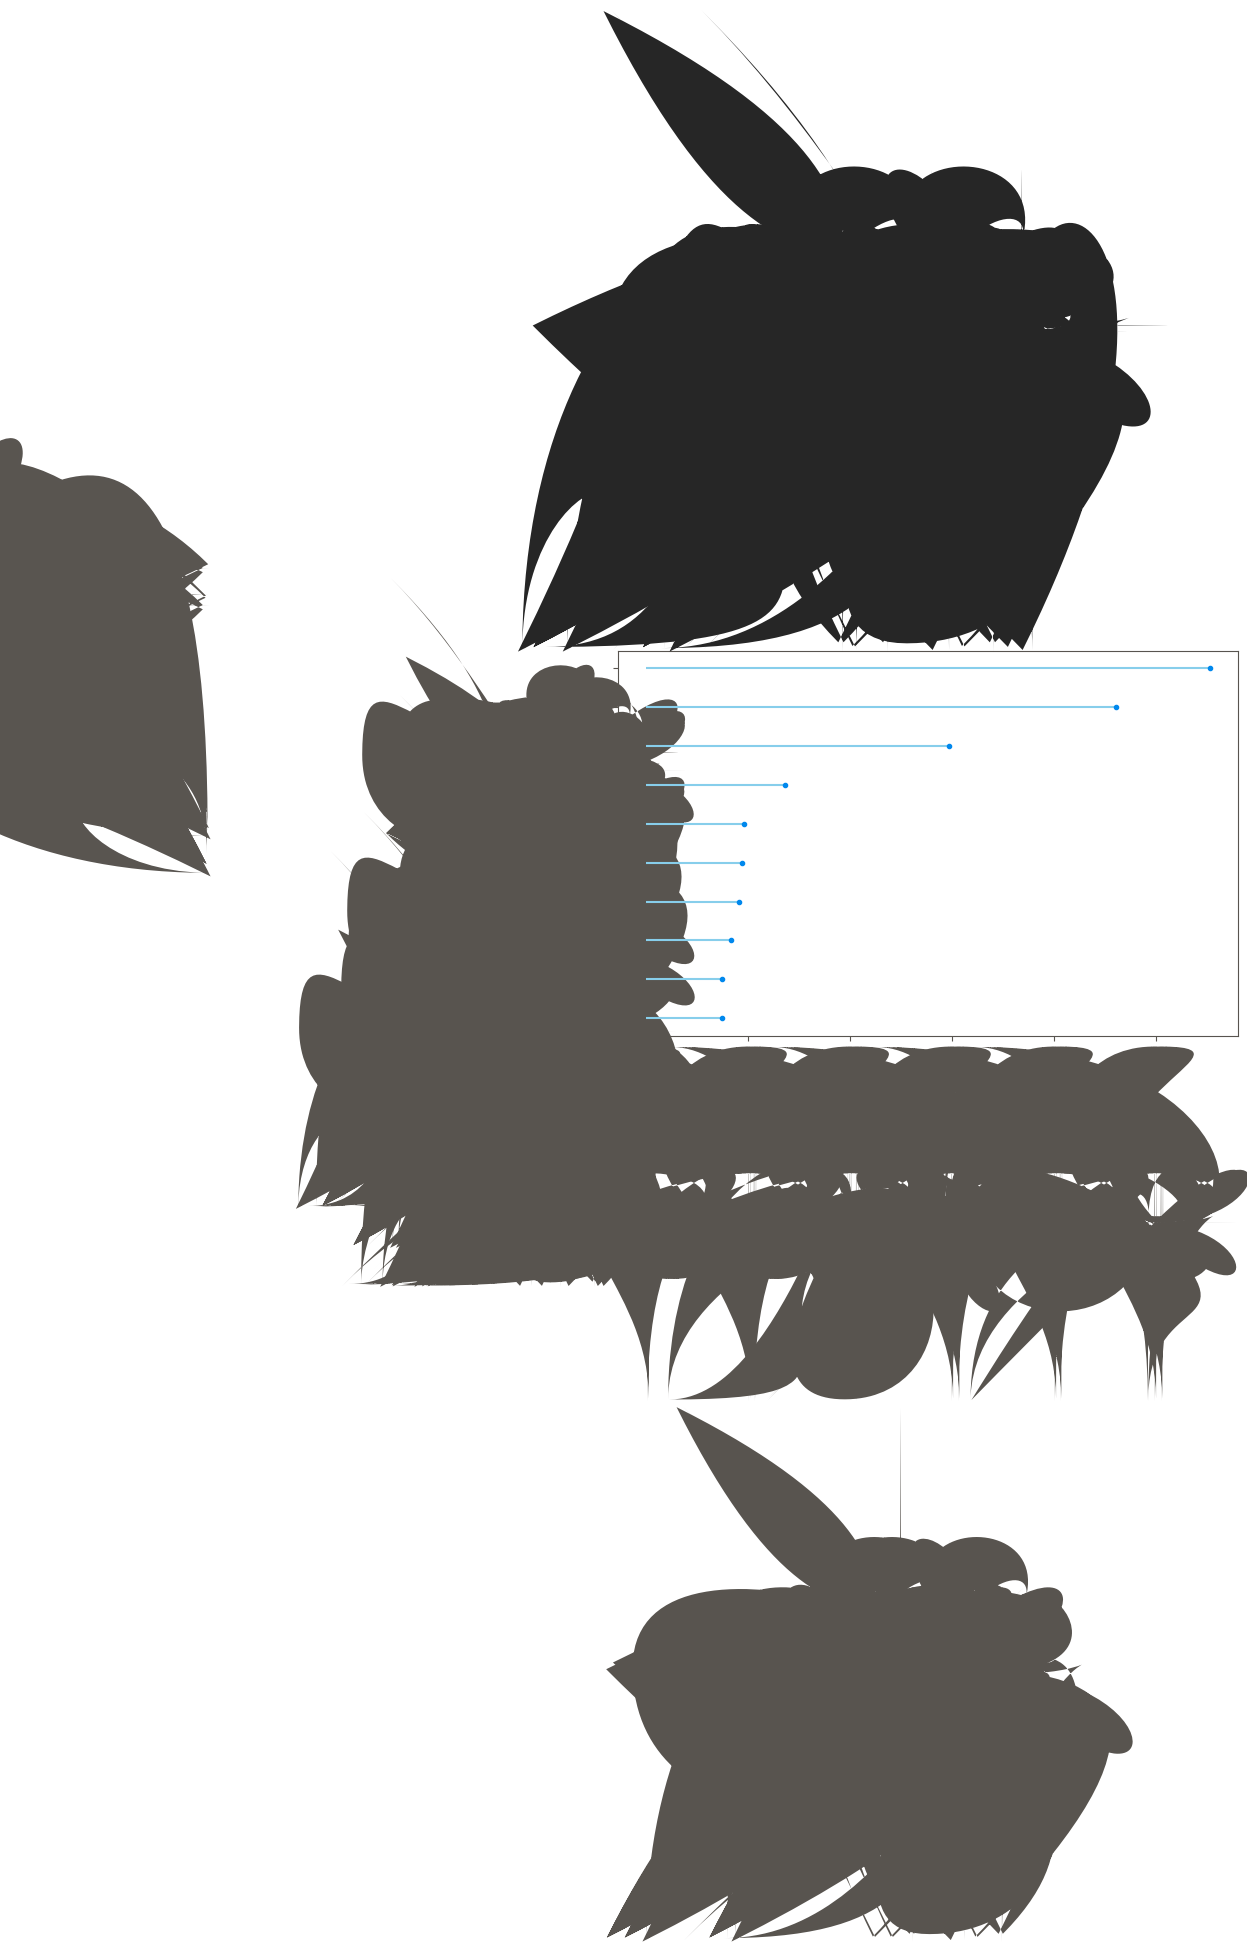

In [37]:
pc.plot_model(best_model, plot="feature")

In [31]:
# predict on test set
test_predictions = pc.predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8979,0.8967,0.8979,0.8881,0.8916,0.4509,0.4565


### Hyperparameter Tuning

In [19]:
# #Fine-tuning the best model
# tuned_best_model = pc.tune_model(
#     estimator=best_model, 
#     fold=3, 
#     optimize='Recall', 
#     search_library='scikit-optimize', 
#     search_algorithm='bayesian', 
#     n_iter=10  # Limit the number of iterations to reduce time
# )

Time to test on test_file.csv


In [21]:
test_data = Input('data/test_file.csv').preprocess()
test_data.head()

,age,job,marital,education,contact,day_of_week,campaign,previous,poutcome,duration_mins,education_level,job_type,income_level,was_contacted_before,deposited_before
0,34,services,married,high.school,telephone,thu,4,0,nonexistent,4,mid,blue-collar,mid,False,False
1,29,blue-collar,single,basic.9y,cellular,thu,1,0,nonexistent,3,low,blue-collar,mid,False,False
2,35,admin.,single,high.school,cellular,wed,2,0,nonexistent,3,mid,white-collar,mid,False,False
3,60,admin.,divorced,high.school,cellular,fri,1,0,nonexistent,3,mid,white-collar,mid,False,False
4,45,management,married,university.degree,telephone,wed,2,0,nonexistent,2,high,white-collar,high,False,False


In [22]:
predictions = pc.predict_model(best_model, data = test_data)

Save file with predictions


In [25]:
predictions.to_excel('data/predictions.xlsx', index=False)


In [39]:
pc.save_model(best_model, 'ml_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['age', 'campaign', 'previous',
                                              'duration_mins'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=Fal...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_d